# COMP41680 - Data Science in Python Assignment - 2
<hr>
> -  <font color='#750252'>**Sumit Kumar** </font>
> -  <font color='#750252'>**1700227**</font>

In [2]:
import requests
import csv
import pandas as pd
import os
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import sklearn
%matplotlib inline

# <font color='#750252'>Part 1: Data Collection</font>
</br>
### <font color='c42542'>Task 1: Web Scrapping</font>

> - Identified the URLs and category labels for all news articles listed on the website below:
> - http://mlg.ucd.ie/modules/COMP41680/archive/index.html
> - Below are listed all the functions that will be used for **Scrapping and Storing** the Text Body in seperate text files



In [3]:
#Creating variables for scrapping and creating/accessing folder
homepage = "http://mlg.ucd.ie/modules/COMP41680/archive/" #link whose contents ate to be scrapped
folder_name = 'news_articles' #Folder to store all the news articles

#Function that parses any given url and returns html for content extraction 
def parse_webpage(request_url):
    response = requests.get(request_url)
    html_text = response.text
    return BeautifulSoup(html_text,'html.parser') #Here the function returns the parsed html page

#Function that scrapes the parsed webpage and returns a list of links(hrefs) in the webpage
def scrape_webpage(suffix,keyword):
    list_of_links =[] #List to carry all the href links
    parsed_page = parse_webpage(homepage + suffix)
    for link_tag in parsed_page.find_all('a'): #Finding all the link tags
        link_href = link_tag.get('href') #Getting the text associated with the href
        if link_href.startswith(keyword): #Checking for text to start with 'month'/'article'
            list_of_links.append(link_href)
    return list_of_links

#Function that extracts the body of the article webpage and sends a command to create the text fle
def scrape_article(article_name):
    parsed_article = parse_webpage(homepage + article_name)
    create_article_file(article_name, parsed_article) #Sending the article name and its html (parsed) content

#Function that creates a text file for each article that has been scrapped.
def create_article_file(filename, article_parsed):
    if not os.path.exists(folder_name): #Checking if the desired folder exists or not
        os.makedirs(folder_name) #Creats the folder/directory if it doesnot exist 
    file_name = folder_name+'/' + filename.rstrip('.html') + '.txt'
    with open(file_name, 'w',encoding='utf-8') as file: #Opening a file in write mode and also assuring the encoding as 'utf-8'
        for link in article_parsed.find_all('p', attrs={'class': None}): #Checking for paragraph tags
            p_text = link.get_text() #Extracting text from the 'p' tags
            if p_text != '':
                file.write(p_text) #Writing the text in file

#Function to create a csv file that contains the Category 
def create_csv_file(title_list,name_list):
    with open('titles_file.csv','w',newline='',encoding='utf-8') as out: #Opening a csv file in write mode and also assuring the encoding as 'utf-8'
        csv_out=csv.writer(out)
        csv_out.writerow(['Article_Category','Article_Title','File_Name']) #Creating the Heading of the Columns
        for row1,row2 in zip(title_list,name_list): #Iterating through 2 lists in parallel
            row = row1[0],row1[1],row2.rstrip('.html')
            csv_out.writerow(row) #Writing each row in csv file
    print('CSV File Created!!')

### <font color='c42542'>Task 2: Article Scrapping & Saving in Text Files</font>

> - Retrieved all web pages corresponding to these article URLs and scrapped the body of all the **Article webpages** for each Month
> - Created seperate Text Files for all the articles containing the content of each news article in **UTF-8** format.
> - Name the Files same as the Article Link Name ***eg. "Article-Jan-0418"***

In [4]:
#Calling appropriate functions to scrape the articles and store them as text files 
month_url = scrape_webpage('index.html', 'month') #Getting list of month links for scrapping
for link in month_url:
    article_url = scrape_webpage(link,'article') #Getting list of article links for scrapping
    for articles in article_url:
        scrape_article(articles) #Scrapping article body and storing them in text file

### <font color='c42542'>Task 3: Saving Category Labels</font>

> - Retrieved the **Article Category, Article Title** and the **Article Link Text** from the Parsed Webpages of all months.
> - Filtered the *redundant and irrelevant* data extracted from the Webpages.
> - Saving the above retrieved data in a **separate CSV file** for labeling the raw text for Classification.

In [5]:
#Process for extraction of article category and its title from the table in the webpage
category_title_list = [] #List to store all the category and title in tuples
file_name_list = []#List that contains the filename(article link name) of all the articles in the same order as that of the category 
for url in month_url:
    parsed_page = parse_webpage(homepage + url) #Parsing pages for all months
    for tag in parsed_page.find_all('tr'): #Searching for all Table Row tags
        category,title = [td for td in tag.stripped_strings] #Extracting text form the two Column tags
        if ((category != 'Article Category') and (category !=  'N/A')): #Filtering out redundant and irrelevant content
            category_title_list.append((category,title)) #Apendind the above in tuple form
    #Now from the same parsed page we extract all the article link names as we save the articles with same name.
    #This will also be written in the CSV file for mapping the raw text with the Article Category
    for linkname_tag in parsed_page.find_all('a'):
        tag_href = linkname_tag.get('href') #Getting the text associated with the href
        if tag_href.startswith('article'): #Checking for text to start with 'article'
            file_name_list.append(tag_href)

In [6]:
#Calling function to write the category and title in csv
create_csv_file(category_title_list,file_name_list)

CSV File Created!!


# <font color='#750252'>Part 2: Text Classification</font>
</br>
### <font color='c42542'>Task 1: Load Documents & Assign Class Labels</font>

> - Identified the URLs and category labels for all news articles listed on the website below:
> - http://mlg.ucd.ie/modules/COMP41680/archive/index.html
> - Below are listed all the functions that will be used for **Scrapping and Storing** the Text Body in seperate text files



In [7]:
#Creating a dataframe that consists of Article Category,Title,Filename,Raw Text 
#Docuents are being labeled for Classification
labeled_dataframe = pd.read_csv('titles_file.csv') #Loading the CSV file in the dataframe
mapping_dict = {} #A dictionary to map the filename in the dataframe to the raw text saved in the 'news_article' folder
#Here manual mapping is required as the text files in the system folder are not in the same order as they were created
for file in os.listdir(folder_name):
    textfile = folder_name + "/" + file
    with open(textfile, "r", encoding = 'utf-8') as tfile: #Opening the file in read mode
        file_name,file_content = file.rstrip(".txt"),tfile.read()
    mapping_dict[file_name] = file_content #Making the filename the keys of the dictionary and its text the value
#Mapping the Raw Text with the File_Name using the map() function
labeled_dataframe['Raw_Text'] = labeled_dataframe['File_Name'].map(mapping_dict)
labeled_dataframe = labeled_dataframe.set_index('File_Name') #Setting the filename as the index of the dataframe
labeled_dataframe.head(10) #Displaying the first 10 rows of the dataframe

,Article_Category,Article_Title,Raw_Text
File_Name,,,
article-jan-0418,technology,21st-Century Sports: How Digital Technology Is...,The sporting industry has come a long way sinc...
article-jan-0027,business,Asian quake hits European shares,Asian quake hits European sharesShares in Euro...
article-jan-0631,technology,BT offers free net phone calls,BT is offering customers free internet telepho...
article-jan-2105,business,Barclays shares up on merger talk,Barclays shares up on merger talkShares in UK ...
article-jan-3300,sport,Barkley fit for match in Ireland,England centre Olly Barkley has been passed fi...
article-jan-4187,sport,Bellamy under new fire,Bellamy under new fireNewcastle boss Graeme So...
article-jan-1974,sport,Benitez 'to launch Morientes bid',Benitez 'to launch Morientes bid'Liverpool may...
article-jan-3666,sport,Benitez delight after crucial win,Liverpool manager Rafael Benitez admitted vict...
article-jan-2629,technology,Big war games battle it out,The arrival of new titles in the popular Medal...


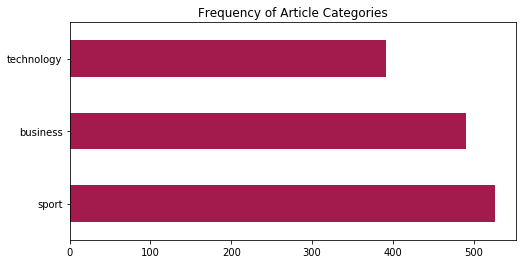

In [8]:
category_dataframe = pd.DataFrame() #Creating empty Dataframe to store the count of labels
category_dataframe = labeled_dataframe.Article_Category.value_counts() #Assigning count of unique Article Category to Dataframe
#Plotting the count/frequency of the labels using a horizontal bar Graph
category_dataframe.plot(kind='barh',color='#a31a4c',title='Frequency of Article Categories',figsize=(8,4))

- From the above plot, it can be seen how the count of the three classes in the Article category column is distributed. There is not much of a difference in the relative count of each of these class. Therefore the model can safely be developed. If there was a lot of imbalance, we might have to resort to under or oversampling during the training and testing phase to minimise the bias.

### <font color='c42542'>Task 2: Pre-Processing Steps</font>

- Retrieved the **Article Category, Article Title** and the **Article Link Text** from the Parsed Webpages of all 
months.
- Steps used to process text input files to reduce the number of terms used to represent the text and to improve the resulting bag-of-words model include:
> - **Minimum term length:** Exclude terms of length < 2. Done by Default in Scikit-learn.
> - **Case conversion:** Converting all terms to lowercase. Scikit-learn does this by default. ALso,Done Manually for precaution
> - **Stop-word filtering:** Removed terms that appeared on a pre-defined "blacklist" of terms which are highly frequent and convey less useful information.
> - **Low frequency filtering:** Remove terms that appear in very few documents. *(min_df = 5)*
> - **Stemming/Lemmatization:** Reduce words to their stems (or base forms).

- The most common normalisation is **term frequency–inverse document frequency (TF-IDF)**

In [9]:
#To use NLTK stemming with Scikit-learn, we need to create a custom tokenisation function:
import nltk #Importing the NLTK Package
from sklearn.feature_extraction.text import TfidfVectorizer #Importing the TF-IDF Vectorizer to create the Term Matrix
#Defining a Function that will Convert to lower case, tokenize and emmatize the raw text
def lemma_tokenizer(raw_text):
    # using the standard scikit-learn tokenizer first to create the tokens.
    standard_tokenizer = TfidfVectorizer().build_tokenizer() #Building tokenizer
    tokens = standard_tokenizer(raw_text.lower()) #Converting text to lowercase and creating tokens
    # then using NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer() #Building the lemmatizer
    lemma_tokens = [] #Empty list for appending lemmatized tokens of each document
    for token in tokens:
        #Now lemmatizing each token and appending each token back to form refined text
        lemma_tokens.append( lemmatizer.lemmatize(token) ) 
    return lemma_tokens

### Term Weighting
> -  ** Create Document-Term Matrix**
> - As well as including/excluding terms, we modified/weighted the frequency values themselves. 
> - Improved the usefulness of the document-term matrix by giving more weight to the more "important" terms.

In [10]:
#Making the corpus by extracting the raw text from the labeled dataframe
corpus = labeled_dataframe.Raw_Text 
#In Scikit-learn, we can generate at TF-IDF weighted document-term matrix by using TfidfVectorizer().
#Building the vectorizer using custom built lemma_tokenizer, choosing englisg stopwords and performing low frequency filtering
vectorizer = TfidfVectorizer(stop_words="english",min_df = 5,tokenizer=lemma_tokenizer)
#Building the tfidf matrix for the corpus created above which will be used for building classification models
tfidf_matrix = vectorizer.fit_transform(corpus)
#Displayig the Shape of matrix built
print(tfidf_matrix.shape)

(1408, 6069)


In [11]:
#Using the pandas dataframe displaying a Document Term Matrix by converting the tfidf matrix to array and transforming it.
dt_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names(), index = labeled_dataframe.index).T
dt_matrix

File_Name,article-jan-0418,article-jan-0027,article-jan-0631,article-jan-2105,article-jan-3300,article-jan-4187,article-jan-1974,article-jan-3666,article-jan-2629,article-jan-2415,...,article-dec-4918,article-dec-2759,article-dec-4347,article-dec-3179,article-dec-1456,article-dec-2238,article-dec-2334,article-dec-2095,article-dec-1351,article-dec-0068
000,0.000000,0.053216,0.027614,0.033884,0.000000,0.000000,0.000000,0.0,0.000000,0.053221,...,0.0,0.00000,0.000000,0.000000,0.102208,0.000000,0.043215,0.022163,0.00000,0.000000
000m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
03,0.000000,0.066325,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
07,0.000000,0.063371,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
10,0.000000,0.052721,0.027358,0.000000,0.037196,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.022799,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
100,0.000000,0.000000,0.000000,0.046909,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
100m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


### <font color='c42542'>Task 3: Building Multi-Class Classification Models</font>

> -  Two multi-class classification models are built using a **K-Nearest Neighnour** Classifier and  **Support Vector Machine** Classifier.
> - We first ***train the classifiers*** on the *labeled training data* to learn from and then use the test data-set to make predictions. 
> - Using **Simple Train/Test Splits** method we perform the training and calculate the accuracy of the classifiers built.

In [12]:
text_variables = tfidf_matrix #Assigning the tf-idf matix to text_varibales for use in splitting and cross-validation
text_labels = labeled_dataframe.Article_Category #Using the Article Category as labels for training the classifier
k_value = [1,3,5] #Different values of k for which the model will be built(for KNN classifier)

### <font color='c42542'>Simple Train/Test Splits:</font>
> - We randomly split the complete dataset into a training test and a test set specifying that 30% (0.3) of the data will be used for the test set.

In [13]:
#Before building the classifier we split the data into two parts 
#One to be used for Training the classifier and the other to test the accuracy of the classifier build on the trained data
#SKLEARN gives us this feature of splitting the Dataset for training and testing
from sklearn.model_selection import train_test_split
#We split the data in 70-30 ratio, 70% for training and 30% for testing randomly
train_data, test_data, target_labels, test_labels = train_test_split(text_variables, text_labels, test_size=.3)

#### KNN Classifier:
> - Now we will build a **KNN classifier** for different values of k *(k=1,3,5)* by only using the training data to build the model:
> - Then make predictions using the test data from which we can measure the accuracy of the model created.

In [14]:
#Importing the KNN Classifier from scikit-learn neighbors
from sklearn.neighbors import KNeighborsClassifier
#Importing all of the scikit-learn evaluation functionality
from sklearn.metrics import *
knn_predict_list = []
for k in k_value:
    knn_classifier = KNeighborsClassifier(n_neighbors=k) #Building Classifier for different k values
    knn_classifier = knn_classifier.fit(train_data,target_labels) #Training the Classifier with the train data and target labels
    knn_predictions = knn_classifier.predict(test_data) #Performing prediction of the test data
    knn_predict_list.append(knn_predictions) #Appending all prediction values to empty list for later use.

> - Next, using the **accuracy_score()** function from *sklearn.metrics* we calculate the accuracy of the model.

In [15]:
knn_ascore = []
for k,p in zip(k_value,range(3)):
    accuracy = accuracy_score(test_labels,knn_predict_list[p]) #Calculating the accuracy using the accuracy_score() function
    knn_ascore.append(accuracy*100) #Appending the accuracy to the empty list
    print("For K=%d -> Accuracy = %.3f" % (k,accuracy) ) #Displaying the result for all k's

For K=1 -> Accuracy = 0.939
For K=3 -> Accuracy = 0.950
For K=5 -> Accuracy = 0.957


> - The above results will be **different each time** we run the split code as the splitting is done randomly
<hr>
> - Now we create a **confusion matrix** for the results calculated above. The result is a NumPy matrix, with predictions on the columns and actual labels on the rows.

In [16]:
for k,p in zip(k_value,range(3)):
    print("For K=%d " % k)
    print(confusion_matrix(test_labels,knn_predict_list[p]))

For K=1 
[[133   2  13]
 [  5 165   3]
 [  2   1  99]]
For K=3 
[[134   1  13]
 [  4 168   1]
 [  1   1 100]]
For K=5 
[[136   2  10]
 [  3 169   1]
 [  1   1 100]]


> - A perfect classifier with 100% accuracy would produce a pure diagonal matrix which would have all the test examples predicted in their correct class. In our case, we see that we have higher values in the diagonal and some values other than that (not pure diagonal matrix)
<hr>
> - Now we compute a summary of these statistics using scikit-learn's provided convenience function: **classification_report()**

In [17]:
for k,p in zip(k_value,range(3)):
    print("For K=%d " % k)
    print(classification_report(test_labels,knn_predict_list[p]))

For K=1 
             precision    recall  f1-score   support

   business       0.95      0.90      0.92       148
      sport       0.98      0.95      0.97       173
 technology       0.86      0.97      0.91       102

avg / total       0.94      0.94      0.94       423

For K=3 
             precision    recall  f1-score   support

   business       0.96      0.91      0.93       148
      sport       0.99      0.97      0.98       173
 technology       0.88      0.98      0.93       102

avg / total       0.95      0.95      0.95       423

For K=5 
             precision    recall  f1-score   support

   business       0.97      0.92      0.94       148
      sport       0.98      0.98      0.98       173
 technology       0.90      0.98      0.94       102

avg / total       0.96      0.96      0.96       423



<hr>
#### Naive Bayes Classifier: Multinomial Naive Bayes
> - Now we will build a **Multinomial Naive Bayes classifier** by only using the training data to build the model:
> - Then make predictions using the test data from which we can measure the accuracy of the model created.

In [18]:
#Importing the MultinimialNB Classifier from scikit-learn naive_bayes
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB() #building the classifier
nb_classifier = nb_classifier.fit(train_data,target_labels) #Training the classifier using training data and labels
nb_prediction = nb_classifier.predict(test_data) #Predicting the classifier on the test data

> - Calculate Accuracy using **accuracy_score()** function from *sklearn.metrics*.

In [19]:
#Measuring the accuracy of the model bulit above
nb_accuracy = accuracy_score(test_labels,nb_prediction)
print('Naive Bayes Accuracy = %.3f' % nb_accuracy) #Formatting the display

Naive Bayes Accuracy = 0.976


> - Creating confusion-matrix for the result shown above.

In [20]:
#Building the confusion matrix using the test labels and predicted values.
nb_c_matrix = confusion_matrix(test_labels,nb_prediction)
print(nb_c_matrix)

[[144   0   4]
 [  4 169   0]
 [  2   0 100]]


> - Showing summary of the statistics.

In [21]:
print(classification_report(test_labels,nb_prediction)) #Displaying the Summary

             precision    recall  f1-score   support

   business       0.96      0.97      0.97       148
      sport       1.00      0.98      0.99       173
 technology       0.96      0.98      0.97       102

avg / total       0.98      0.98      0.98       423



- There are three types of Naive Bayes model under Scikit-learn library: <font color='blue'>**Gaussian, Bernoulli, and Multinomial**</font>
- Above used is the Multinomial Naive Bayes, the reason to select this type is that Bernoulli Naive Bayes just uses the fact that whether a feature is present or not. But here we also take into account the occurrence weight or count of the feature as well (the TFIDF weight).

<hr>
### <font color='c42542'>Task 4: Applying an Evaluation Strategy </font>
- **K-Fold Cross Validation**
- When we perform data analysis using machine learning, we normally split our data into to subsets: training data and testing data, and fit our model on the training data, and make predictions on the test data set. In this process, one of two things may happen: either we overfit the model, or we underfit it. This affects the predictability of our model.
- Also, randomly splitting a dataset into two sets might give different results. This is where cross validation comes in role. 
> - We are performing **k-fold cross validation** where we divide the data into k disjoint subsets (here k=10).
> - For each of k experiments, use k-1 folds for training and the selected one fold for testing.
> - Repeat for all k folds, average the accuracy/error rates.

In [22]:
#Importing the cross validation function from the sklearn model to perform cross validation
from sklearn.model_selection import cross_val_score
import numpy as np #Importing numpy to calculate mean of the accuracies generated from cross validation

#### KNN-Classifier:

In [23]:
#Building the classifier and checking accuracy for different values of k
knn_cv_mscore = [] #Empty list to store accuracy values
k_value_cv = [1,3,5,7,13,201,501] #list of different values of k
for k in k_value_cv: 
    knn_cv = KNeighborsClassifier(n_neighbors=k) #Building the classifier for different k's
    #Calculating accuracy for 10-fold cross validation on complete data set (not splitting manually)
    knn_cv_accuracy = cross_val_score(knn_cv,text_variables,text_labels,cv=10,scoring='accuracy')
    #As the above step gives a numpy array of accuracies we calculate the mean of it.
    knn_mean_accuracy = knn_cv_accuracy.mean()
    knn_cv_mscore.append(knn_mean_accuracy*100) #Adding mean accuracy to empty list for plotting
    print("For K=%d - Mean Accuracy=%.3f" % (k,knn_mean_accuracy) ) #Displaying the Accuracy

For K=1 - Mean Accuracy=0.952
For K=3 - Mean Accuracy=0.957
For K=5 - Mean Accuracy=0.961
For K=7 - Mean Accuracy=0.963
For K=13 - Mean Accuracy=0.968
For K=201 - Mean Accuracy=0.965
For K=501 - Mean Accuracy=0.955


> - Above results will be same each time we run the process for 10 folds because unlike split/train method here we take into account the mean of all the folds which will remain the same for the entire dataset.
<hr>
> - Now we **plot the accuracy** of the model for different values of k, to check how the models performs on varying the parameter.

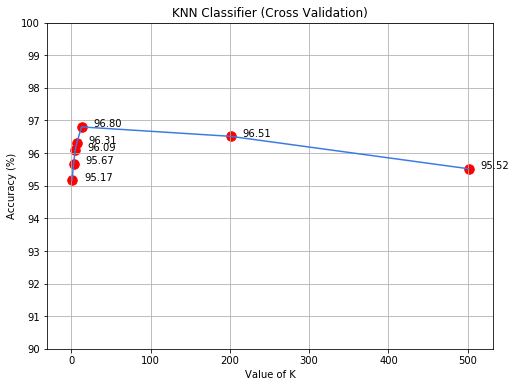

In [27]:
#Plotting Accuracy vs K for Cross Validation
plt.figure(figsize=(8,6))
plt.plot(k_value_cv,knn_cv_mscore,linewidth=1.5,color='#3c7be0') #Showing a line plot
plt.scatter(k_value_cv,knn_cv_mscore,color='red',marker='o',s=90) #Showing scatter plot for highlighting the values
plt.xlabel('Value of K') #Labeling the X-Axis
plt.ylabel('Accuracy (%)') #Labeling the Y-Axis
plt.title('KNN Classifier (Cross Validation)') #Adding a title to the plot
plt.yticks(range(90,101)) #Setting the Y-axis values
for i, txt in enumerate(knn_cv_mscore): #Loop to annotate the accuracy values
    plt.annotate('%.2f'%txt, (k_value_cv[i]+15,knn_cv_mscore[i])) #Adding 0.4 to the y values so that the text is displayed clearly
plt.grid() #Displaying the grid
plt.show() #Finally displaying the plot

- We can see from the above plot that the Accuracy is <font color='red'>highest for k=13 (Accuracy = 96.8%)</font> and then decreases thereafter for very high values.
- Increasing **'k'** will decrease **variance** and increase **bias**. While decreasing **'k'** will increase **variance** and decrease **bias**.This is known as the <font color='red'>**Bias-Variance Tradeoff**.</font> Ref: http://scott.fortmann-roe.com/docs/BiasVariance.html

#### Multinomial Naive Bayes-Classifier:

In [28]:
nb_cv = MultinomialNB() #Building Multinomial Naive Bayes Classifier
#Calculating accuracy for 10-fold cross validation on complete data set (not splitting manually)
nb_cv_accuracy = cross_val_score(nb_cv,text_variables,text_labels,cv=10,scoring='accuracy')
#Above step gives a numpy array of accuracies hence we calculate the mean of it.
nb_mean_accuracy = nb_cv_accuracy.mean()
print("Mean Accuracy = %.3f" % nb_mean_accuracy) #Displaying the accuracy

Mean Accuracy = 0.979


<hr>
# <font color='#750252'> Conclusion: </font>

- The accuracy of Naive Bayes Classifier is almost the same in both the evaluation process (i.e Split/Train and Cross-Validation, but for KNN Classifier it may vary or be almost similar depending on the random split.
- From the above plot, we can see that Between the two classifiers it can be gathered from the metrics that there is not a big difference in accuracy but with a slight margin **Multinomial Naive Bayes** is the winner. 
- Also on comparing the classification metrics (Precision, Recall, F1-Score) of both the classifiers, we see that Multinomial Naive Bayes performs better.
> - Naive Bayes classifiers, are based on the popular Bayes’ probability theorem, and are known for creating simple yet well performing models, especially in the fields of document classification.
> - Being an eager learner, naive Bayes classifiers are known to be relatively fast in classifying new instances.
> - Naive Bayes is also not depended on any parameter like KNN , where it is difficult to select an appropriate value to get a higher accuracy.